In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [100]:
base_dir = './data/Cropped Dataset/'
# uncomment the following line to use non-pre-processed data
# base_dir = './data/New Masks Dataset/'
train_dir = base_dir + 'Train/'
val_dir = base_dir + 'Validation/'
test_dir = base_dir + 'Test/'
batch_size = 32

data_gen_args_base = dict(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False
)

# training data
train_data_generator = ImageDataGenerator(**data_gen_args_base)
train_set = train_data_generator.flow_from_directory(directory=train_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# validation data
val_data_generator = ImageDataGenerator(**data_gen_args_base)
val_set = val_data_generator.flow_from_directory(directory=val_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# test data
test_data_generator = ImageDataGenerator(**data_gen_args_base)
test_set = test_data_generator.flow_from_directory(directory=test_dir,
                                                    target_size=(128, 128),
                                                    batch_size=batch_size,
                                                    class_mode='binary')


Found 311 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


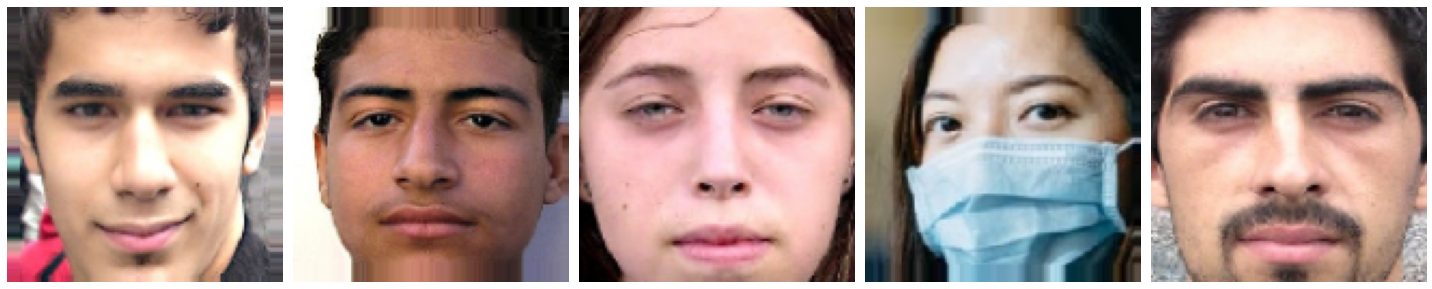

In [101]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_set)
plotImages(sample_training_images[:5])

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization

In [103]:
cnn = Sequential()
cnn.add(Conv2D(32, activation='relu', kernel_size=3, input_shape=[128,128,3]))
# https://www.quora.com/Why-does-batch-normalization-help
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, activation = 'relu', kernel_size = 3))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(2, activation = 'softmax'))

cnn.compile(optimizer='adam', metrics = 'accuracy', loss = 'binary_crossentropy')



In [104]:
history = cnn.fit(x=train_set, epochs=20, validation_data=val_set)

Epoch 1/20
10/10 [==============================] - 8s 788ms/step - loss: 2.8748 - accuracy: 0.8617 - val_loss: 1.5592 - val_accuracy: 0.7153
Epoch 2/20
10/10 [==============================] - 8s 785ms/step - loss: 2.4822 - accuracy: 0.8971 - val_loss: 6.3741 - val_accuracy: 0.7153
Epoch 3/20
10/10 [==============================] - 8s 774ms/step - loss: 3.4548 - accuracy: 0.9260 - val_loss: 1.6419 - val_accuracy: 0.8125
Epoch 4/20
10/10 [==============================] - 8s 787ms/step - loss: 1.9657 - accuracy: 0.9518 - val_loss: 0.8602 - val_accuracy: 0.8056
Epoch 5/20
10/10 [==============================] - 8s 772ms/step - loss: 0.7422 - accuracy: 0.9582 - val_loss: 1.0848 - val_accuracy: 0.8125
Epoch 6/20
10/10 [==============================] - 8s 770ms/step - loss: 0.8532 - accuracy: 0.9646 - val_loss: 3.6442 - val_accuracy: 0.7292
Epoch 7/20
10/10 [==============================] - 8s 772ms/step - loss: 1.4378 - accuracy: 0.9678 - val_loss: 1.4569 - val_accuracy: 0.7917
Epoch 

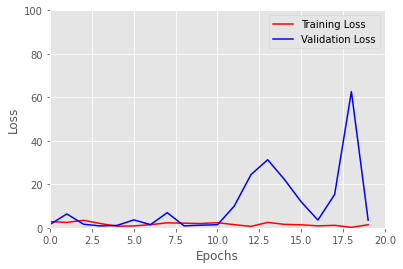

In [105]:
plt.xlim(0, 20)
plt.ylim(0,100)

plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

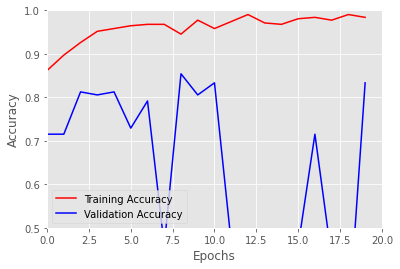

In [106]:
plt.xlim(0, 20)
plt.ylim(0.5,1)

plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [107]:
result = cnn.evaluate(test_set)
dict(zip(cnn.metrics_names, result))

2/2 [==============================] - 0s 36ms/step - loss: 0.5654 - accuracy: 0.9388


{'loss': 0.5654401779174805, 'accuracy': 0.9387755393981934}